## Multiclass Fish Image Classification

### Problem Statement
This project focuses on classifying fish images into multiple categories using deep learning models. The task involves training a CNN from scratch and leveraging transfer learning with pre-trained models to enhance performance. The project also includes saving models for later use and deploying a Streamlit application to predict fish categories from user-uploaded images.

---

### Approach:
**Data Preprocessing and Augmentation**

*  Rescale images to [0, 1] range.
*  Apply data augmentation techniques like rotation, zoom, and flipping to enhance model  robustness.
    
**Model Training**

* Train a CNN model from scratch.
* Experiment with five pre-trained models (e.g., VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB0).
*	Fine-tune the pre-trained models on the fish dataset.
*	Save the trained model (max accuracy model ) in .h5 or .pkl format for future use.

**Model Evaluation** 

*	Compare metrics such as accuracy, precision, recall, F1-score, and confusion matrix across all models.
*	Visualize training history (accuracy and loss) for each model.


**Deployment**

*	Build a Streamlit application to:
*	Allow users to upload fish images.
*	Predict and display the fish category.
*	Provide model confidence scores.
---

### Importing necessary libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
from PIL import Image

### Loading of Dataset 

In [2]:
# Define image dimensions and batch size
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

# Path to the dataset
train_dir = r'C:\Users\adity\Downloads\Fish Classification\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\train'
val_dir = r'C:\Users\adity\Downloads\Fish Classification\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\val'
test_dir = r'C:\Users\adity\Downloads\Fish Classification\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\test'



### Data Preprocessing and Augmentation

In [3]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

num_classes = train_generator.num_classes
class_names = list(train_generator.class_indices.keys())
print(f"Found {num_classes} classes: {class_names}")

Found 6226 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.
Found 11 classes: ['animal fish', 'animal fish bass', 'fish sea_food black_sea_sprat', 'fish sea_food gilt_head_bream', 'fish sea_food hourse_mackerel', 'fish sea_food red_mullet', 'fish sea_food red_sea_bream', 'fish sea_food sea_bass', 'fish sea_food shrimp', 'fish sea_food striped_red_mullet', 'fish sea_food trout']


### Custom CNN

In [4]:
def create_custom_cnn(input_shape, num_classes):
    # Use the Input layer as the first layer to define the input shape
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create and compile the custom CNN
custom_cnn_model = create_custom_cnn((IMG_WIDTH, IMG_HEIGHT, 3), num_classes)

### Compilation and Callback

In [5]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('custom_cnn_best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
]


custom_cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Training

In [6]:

history_custom_cnn = custom_cnn_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=callbacks
)

C:\Users\adity\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.2464 - loss: 2.2403

195/195 ━━━━━━━━━━━━━━━━━━━━ 131s 667ms/step - accuracy: 0.2467 - loss: 2.2386 - val_accuracy: 0.4963 - val_loss: 1.4309 - learning_rate: 0.0010
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.4753 - loss: 1.4366

195/195 ━━━━━━━━━━━━━━━━━━━━ 139s 650ms/step - accuracy: 0.4755 - loss: 1.4361 - val_accuracy: 0.7234 - val_loss: 0.8836 - learning_rate: 0.0010
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.6199 - loss: 1.0495

195/195 ━━━━━━━━━━━━━━━━━━━━ 141s 722ms/step - accuracy: 0.6201 - loss: 1.0493 - val_accuracy: 0.7317 - val_loss: 0.7509 - learning_rate: 0.0010
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - accuracy: 0.7195 - loss: 0.8052

195/195 ━━━━━━━━━━━━━━━━━━━━ 167s 859ms/step - accuracy: 0.7195 - loss: 0.8050 - val_accuracy: 0.8489 - val_loss: 0.5236 - learning_rate: 0.0010
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 162s 832ms/step - accuracy: 0.7580 - loss: 0.7005 - val_accuracy: 0.8114 - val_loss: 0.4943 - learning_rate: 0.0010
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.8030 - loss: 0.5591

195/195 ━━━━━━━━━━━━━━━━━━━━ 162s 829ms/step - accuracy: 0.8031 - loss: 0.5590 - val_accuracy: 0.8544 - val_loss: 0.4478 - learning_rate: 0.0010
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.8320 - loss: 0.5027

195/195 ━━━━━━━━━━━━━━━━━━━━ 150s 770ms/step - accuracy: 0.8320 - loss: 0.5026 - val_accuracy: 0.9020 - val_loss: 0.3121 - learning_rate: 0.0010
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.8544 - loss: 0.4354

195/195 ━━━━━━━━━━━━━━━━━━━━ 129s 662ms/step - accuracy: 0.8543 - loss: 0.4354 - val_accuracy: 0.9158 - val_loss: 0.2580 - learning_rate: 0.0010
Epoch 9/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.8685 - loss: 0.3880

195/195 ━━━━━━━━━━━━━━━━━━━━ 126s 645ms/step - accuracy: 0.8685 - loss: 0.3879 - val_accuracy: 0.9451 - val_loss: 0.2000 - learning_rate: 0.0010
Epoch 10/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 126s 647ms/step - accuracy: 0.8728 - loss: 0.3589 - val_accuracy: 0.9112 - val_loss: 0.2657 - learning_rate: 0.0010
Epoch 11/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.8633 - loss: 0.3818

195/195 ━━━━━━━━━━━━━━━━━━━━ 126s 647ms/step - accuracy: 0.8634 - loss: 0.3818 - val_accuracy: 0.9478 - val_loss: 0.1779 - learning_rate: 0.0010
Epoch 12/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.8875 - loss: 0.3132

195/195 ━━━━━━━━━━━━━━━━━━━━ 126s 644ms/step - accuracy: 0.8875 - loss: 0.3132 - val_accuracy: 0.9579 - val_loss: 0.1519 - learning_rate: 0.0010
Epoch 13/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.9036 - loss: 0.2782

195/195 ━━━━━━━━━━━━━━━━━━━━ 126s 643ms/step - accuracy: 0.9036 - loss: 0.2782 - val_accuracy: 0.9716 - val_loss: 0.1214 - learning_rate: 0.0010
Epoch 14/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 125s 641ms/step - accuracy: 0.9170 - loss: 0.2582 - val_accuracy: 0.9625 - val_loss: 0.1514 - learning_rate: 0.0010
Epoch 15/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 125s 639ms/step - accuracy: 0.9086 - loss: 0.2674 - val_accuracy: 0.9286 - val_loss: 0.2081 - learning_rate: 0.0010
Epoch 16/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 125s 639ms/step - accuracy: 0.9219 - loss: 0.2304 - val_accuracy: 0.9341 - val_loss: 0.2237 - learning_rate: 0.0010
Epoch 17/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.9312 - loss: 0.2058

195/195 ━━━━━━━━━━━━━━━━━━━━ 127s 648ms/step - accuracy: 0.9312 - loss: 0.2056 - val_accuracy: 0.9835 - val_loss: 0.0881 - learning_rate: 2.0000e-04
Epoch 18/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 125s 641ms/step - accuracy: 0.9513 - loss: 0.1483 - val_accuracy: 0.9826 - val_loss: 0.0857 - learning_rate: 2.0000e-04
Epoch 19/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 125s 638ms/step - accuracy: 0.9542 - loss: 0.1299 - val_accuracy: 0.9835 - val_loss: 0.0731 - learning_rate: 2.0000e-04
Epoch 20/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.9589 - loss: 0.1202

195/195 ━━━━━━━━━━━━━━━━━━━━ 125s 642ms/step - accuracy: 0.9589 - loss: 0.1201 - val_accuracy: 0.9844 - val_loss: 0.0722 - learning_rate: 2.0000e-04


### Evaluation and Visualization

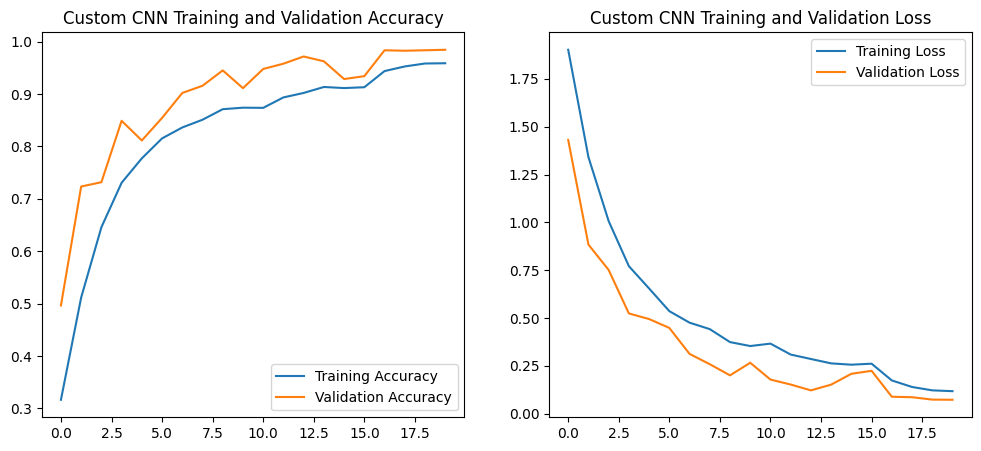

In [7]:
def plot_training_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.legend()
    plt.show()

# Plot training history 
plot_training_history(history_custom_cnn, 'Custom CNN')

### VGG16

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam


def build_vgg16_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  

    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

vgg16_model = build_vgg16_model((IMG_WIDTH, IMG_HEIGHT, 3), num_classes)
history_vgg16 = vgg16_model.fit(train_generator, epochs=20, validation_data=validation_generator)
vgg16_model.save('vgg16_fish_classifier.h5')

Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 583s 3s/step - accuracy: 0.4234 - loss: 1.7532 - val_accuracy: 0.8773 - val_loss: 0.5786
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 615s 3s/step - accuracy: 0.7441 - loss: 0.7946 - val_accuracy: 0.9011 - val_loss: 0.3746
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 608s 3s/step - accuracy: 0.8330 - loss: 0.5548 - val_accuracy: 0.9258 - val_loss: 0.2551
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 742s 4s/step - accuracy: 0.8567 - loss: 0.4430 - val_accuracy: 0.9560 - val_loss: 0.1923
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 1263s 6s/step - accuracy: 0.8852 - loss: 0.3647 - val_accuracy: 0.9625 - val_loss: 0.1503
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 1311s 7s/step - accuracy: 0.9033 - loss: 0.3184 - val_accuracy: 0.9725 - val_loss: 0.1239
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 1087s 6s/step - accuracy: 0.9109 - loss: 0.2890 - val_accuracy: 0.9725 - val_loss: 0.1129
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 1053s 5s/step - accuracy: 0.9061 - loss: 0.2856 - val_

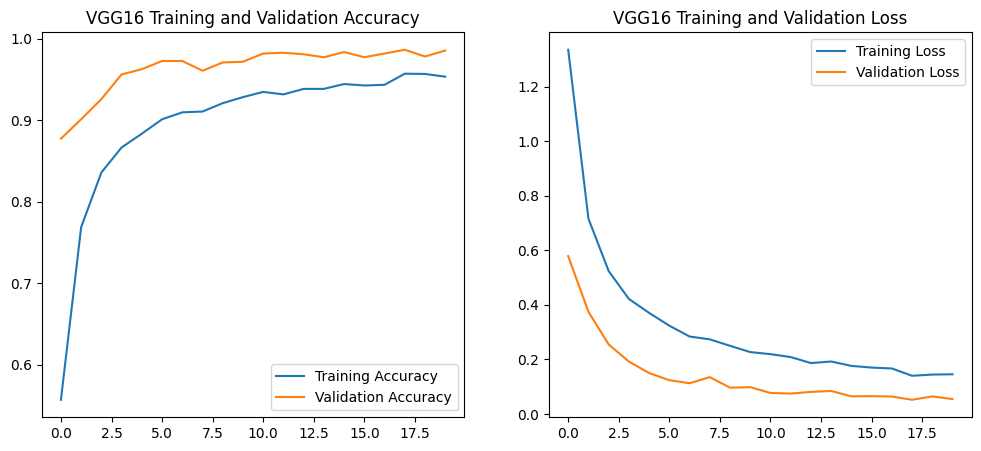

In [9]:
def plot_training_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.legend()
    plt.show()

# Plot training history 
plot_training_history(history_vgg16, 'VGG16')

### ResNet50

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def build_resnet50_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

resnet50_model = build_resnet50_model((IMG_WIDTH, IMG_HEIGHT, 3), num_classes)
history_resnet50 = resnet50_model.fit(train_generator, epochs=20, validation_data=validation_generator)
resnet50_model.save('resnet50_fish_classifier.h5')

Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.1081 - loss: 2.6952 - val_accuracy: 0.1712 - val_loss: 2.2924
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.1602 - loss: 2.3178 - val_accuracy: 0.1712 - val_loss: 2.2750
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.1684 - loss: 2.2952 - val_accuracy: 0.1712 - val_loss: 2.2509
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.1870 - loss: 2.2797 - val_accuracy: 0.1712 - val_loss: 2.2320
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.1795 - loss: 2.2598 - val_accuracy: 0.1685 - val_loss: 2.2192
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - accuracy: 0.1812 - loss: 2.2394 - val_accuracy: 0.1612 - val_loss: 2.1955
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.1876 - loss: 2.2308 - val_accuracy: 0.1832 - val_loss: 2.1789
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.1885 - loss: 2.2215 - val_accu

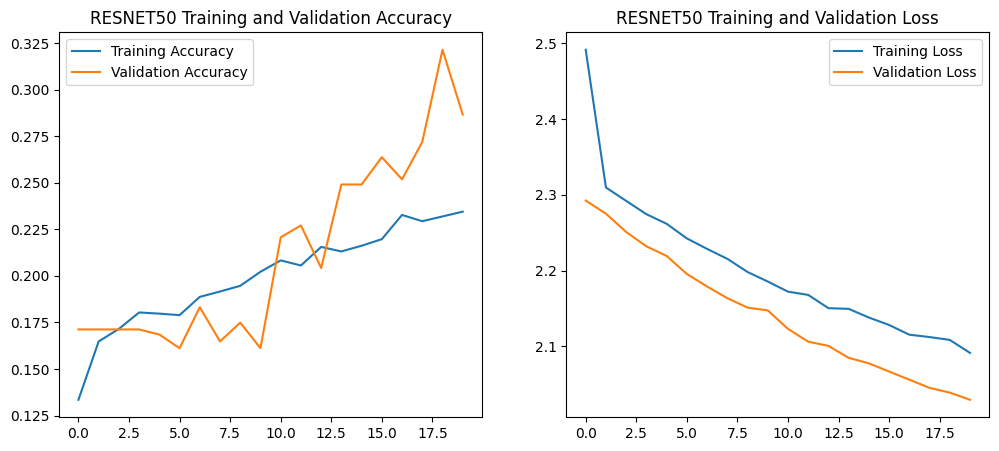

In [11]:
def plot_training_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.legend()
    plt.show()


plot_training_history(history_resnet50, 'RESNET50')

### MobileNet

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def build_mobilenet_model(input_shape, num_classes):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

mobilenet_model = build_mobilenet_model((IMG_WIDTH, IMG_HEIGHT, 3), num_classes)
history_mobilenet = mobilenet_model.fit(train_generator, epochs=20, validation_data=validation_generator)
mobilenet_model.save('mobilenet_fish_classifier.h5')

Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 145s 724ms/step - accuracy: 0.2770 - loss: 2.3031 - val_accuracy: 0.8095 - val_loss: 0.9485
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 139s 713ms/step - accuracy: 0.6394 - loss: 1.1156 - val_accuracy: 0.9057 - val_loss: 0.5050
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 140s 717ms/step - accuracy: 0.7805 - loss: 0.7104 - val_accuracy: 0.9350 - val_loss: 0.3429
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 143s 732ms/step - accuracy: 0.8400 - loss: 0.5370 - val_accuracy: 0.9505 - val_loss: 0.2413
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 150s 771ms/step - accuracy: 0.8714 - loss: 0.4324 - val_accuracy: 0.9634 - val_loss: 0.1884
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 146s 746ms/step - accuracy: 0.8967 - loss: 0.3376 - val_accuracy: 0.9679 - val_loss: 0.1494
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 142s 728ms/step - accuracy: 0.9238 - loss: 0.2869 - val_accuracy: 0.9707 - val_loss: 0.1184
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 134s 689ms/step - accuracy: 0.9232 -

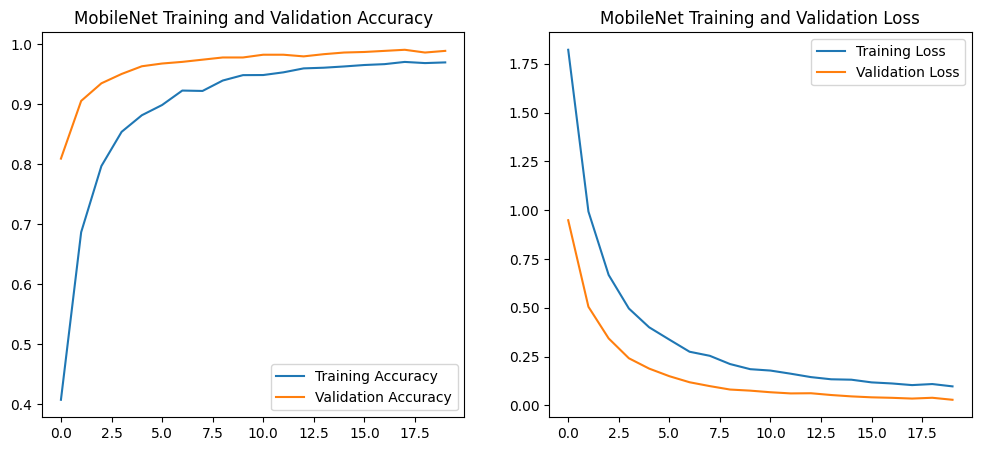

In [13]:
def plot_training_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.legend()
    plt.show()

# Plot training history 
plot_training_history(history_mobilenet, 'MobileNet')

### InceptionV3

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def build_inceptionv3_model(input_shape, num_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

inceptionv3_model = build_inceptionv3_model((IMG_WIDTH, IMG_HEIGHT, 3), num_classes)
history_inceptionv3 = inceptionv3_model.fit(train_generator, epochs=20, validation_data=validation_generator)
inceptionv3_model.save('inceptionv3_fish_classifier.h5')

Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 861s 4s/step - accuracy: 0.2925 - loss: 2.2411 - val_accuracy: 0.8068 - val_loss: 0.8962
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 846s 4s/step - accuracy: 0.6659 - loss: 1.0397 - val_accuracy: 0.8974 - val_loss: 0.5148
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 842s 4s/step - accuracy: 0.7808 - loss: 0.7263 - val_accuracy: 0.9057 - val_loss: 0.3845
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 913s 4s/step - accuracy: 0.8212 - loss: 0.5996 - val_accuracy: 0.9277 - val_loss: 0.2984
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 588s 3s/step - accuracy: 0.8421 - loss: 0.5155 - val_accuracy: 0.9368 - val_loss: 0.2465
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.8639 - loss: 0.4388 - val_accuracy: 0.9478 - val_loss: 0.2170
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.8745 - loss: 0.4064 - val_accuracy: 0.9460 - val_loss: 0.1965
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.8912 - loss: 0.3580 - val_accu

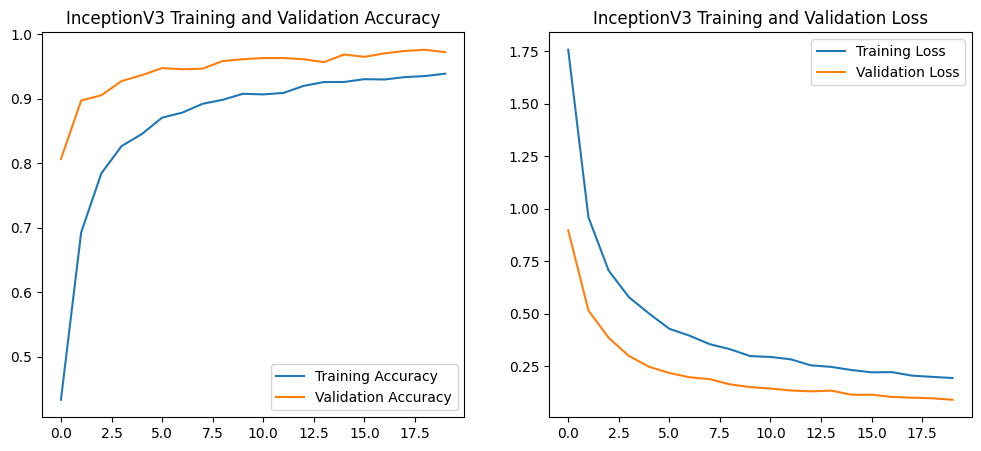

In [15]:
def plot_training_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.legend()
    plt.show()

# Plot training history for Custom CNN
plot_training_history(history_inceptionv3, 'InceptionV3')

### EfficientNetB0

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def build_efficientnetb0_model(input_shape, num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

efficientnetb0_model = build_efficientnetb0_model((IMG_WIDTH, IMG_HEIGHT, 3), num_classes)
history_efficientnetb0 = efficientnetb0_model.fit(train_generator, epochs=20, validation_data=validation_generator)
efficientnetb0_model.save('efficientnetb0_fish_classifier.h5')

Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 179s 851ms/step - accuracy: 0.1370 - loss: 2.3659 - val_accuracy: 0.1712 - val_loss: 2.3191
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 166s 851ms/step - accuracy: 0.1718 - loss: 2.3325 - val_accuracy: 0.1712 - val_loss: 2.3178
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 201s 844ms/step - accuracy: 0.1597 - loss: 2.3298 - val_accuracy: 0.1712 - val_loss: 2.3176
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 214s 905ms/step - accuracy: 0.1696 - loss: 2.3199 - val_accuracy: 0.1712 - val_loss: 2.3138
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 168s 863ms/step - accuracy: 0.1605 - loss: 2.3293 - val_accuracy: 0.1712 - val_loss: 2.3121
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 164s 841ms/step - accuracy: 0.1600 - loss: 2.3315 - val_accuracy: 0.1712 - val_loss: 2.3152
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 196s 813ms/step - accuracy: 0.1604 - loss: 2.3241 - val_accuracy: 0.1712 - val_loss: 2.3119
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 160s 819ms/step - accuracy: 0.1757 -

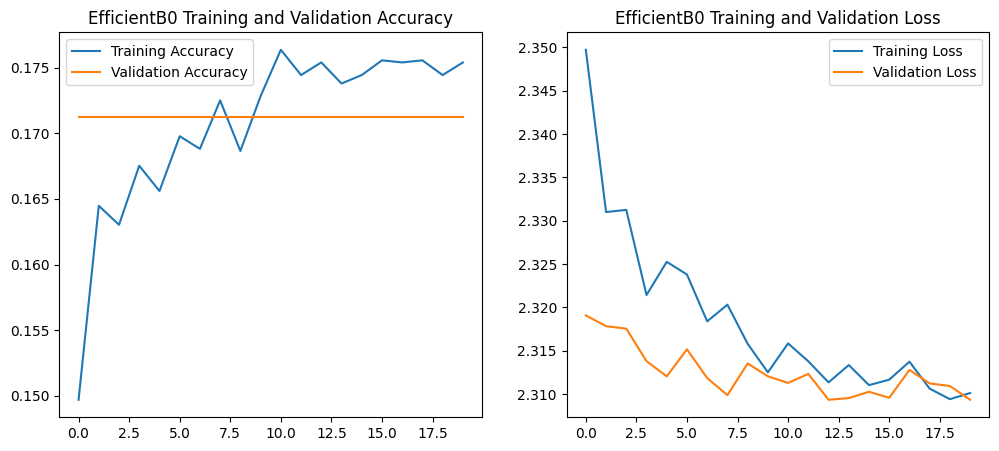

In [17]:
def plot_training_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.legend()
    plt.show()

# Plot training history for Custom CNN
plot_training_history(history_efficientnetb0, 'EfficientB0')

### Comparison

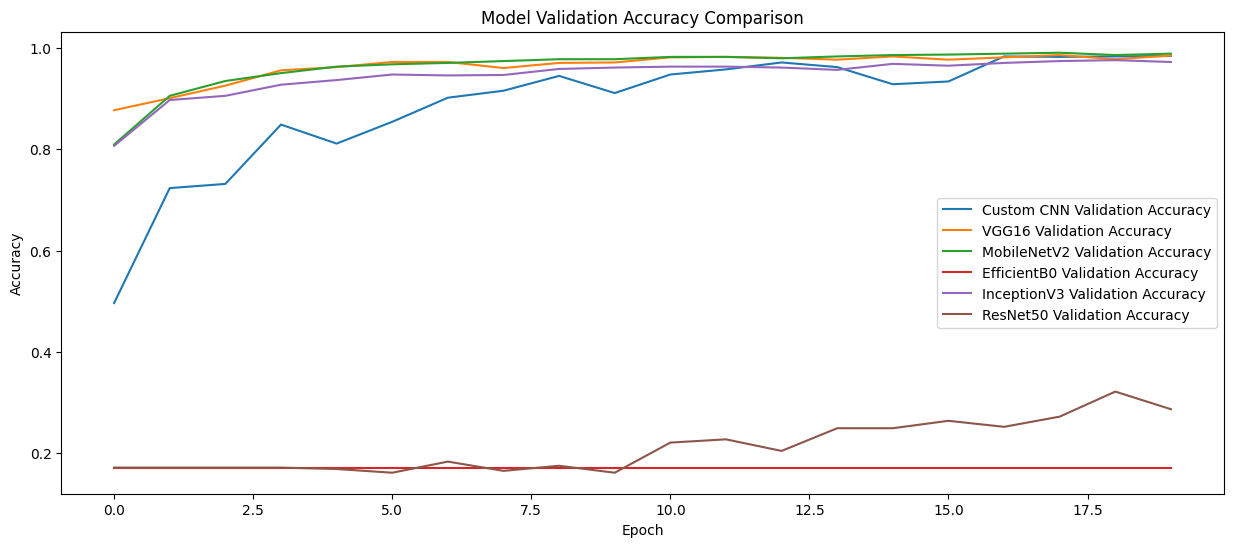

In [19]:
def plot_model_comparison(histories):
    plt.figure(figsize=(15, 6))
    for name, history in histories.items():
        plt.plot(history.history['val_accuracy'], label=f'{name} Validation Accuracy')
    plt.title('Model Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

histories = {
    'Custom CNN': history_custom_cnn,
    'VGG16': history_vgg16,
    'MobileNetV2': history_mobilenet,
    'EfficientB0' : history_efficientnetb0,
    'InceptionV3' : history_inceptionv3,
    'ResNet50' : history_resnet50,
}
plot_model_comparison(histories)

### Confusion Matrix

100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step

--- Custom CNN Evaluation ---

Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.16      0.16      0.16       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.10      0.10      0.10       298
   fish sea_food gilt_head_bream       0.08      0.08      0.08       305
   fish sea_food hourse_mackerel       0.06      0.06      0.06       286
        fish sea_food red_mullet       0.09      0.09      0.09       291
     fish sea_food red_sea_bream       0.09      0.09      0.09       273
          fish sea_food sea_bass       0.10      0.11      0.10       327
            fish sea_food shrimp       0.10      0.10      0.10       289
fish sea_food striped_red_mullet       0.07      0.06      0.07       293
             fish sea_food trout       0.09      0.10      0.10       292

           

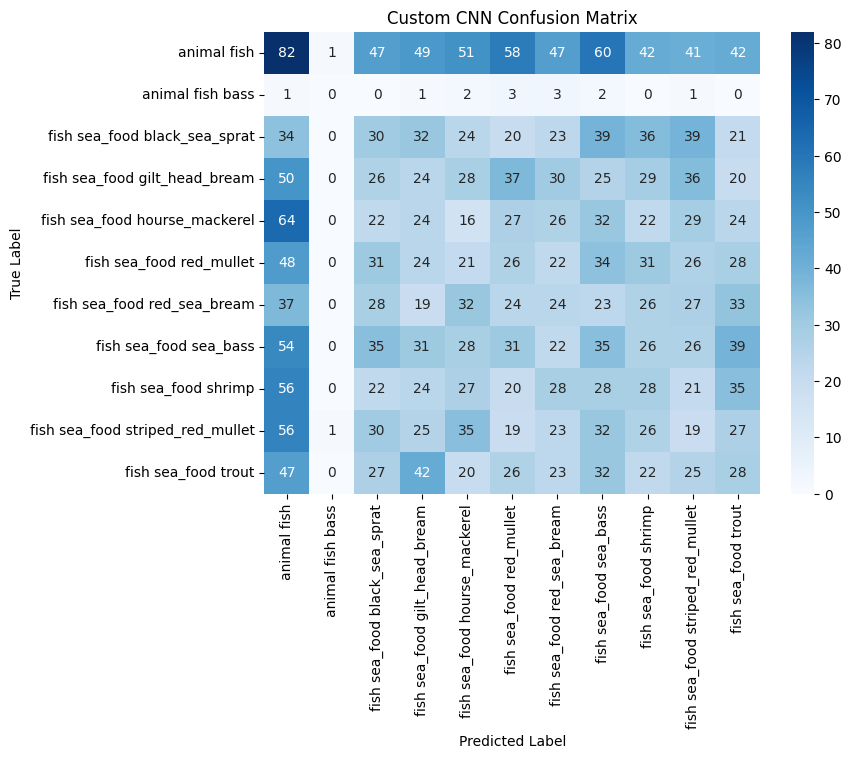

100/100 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step

--- VGG16 Evaluation ---

Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.16      0.17      0.16       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.08      0.08      0.08       298
   fish sea_food gilt_head_bream       0.09      0.09      0.09       305
   fish sea_food hourse_mackerel       0.12      0.12      0.12       286
        fish sea_food red_mullet       0.10      0.10      0.10       291
     fish sea_food red_sea_bream       0.07      0.07      0.07       273
          fish sea_food sea_bass       0.09      0.09      0.09       327
            fish sea_food shrimp       0.10      0.10      0.10       289
fish sea_food striped_red_mullet       0.08      0.08      0.08       293
             fish sea_food trout       0.09      0.09      0.09       292

                  

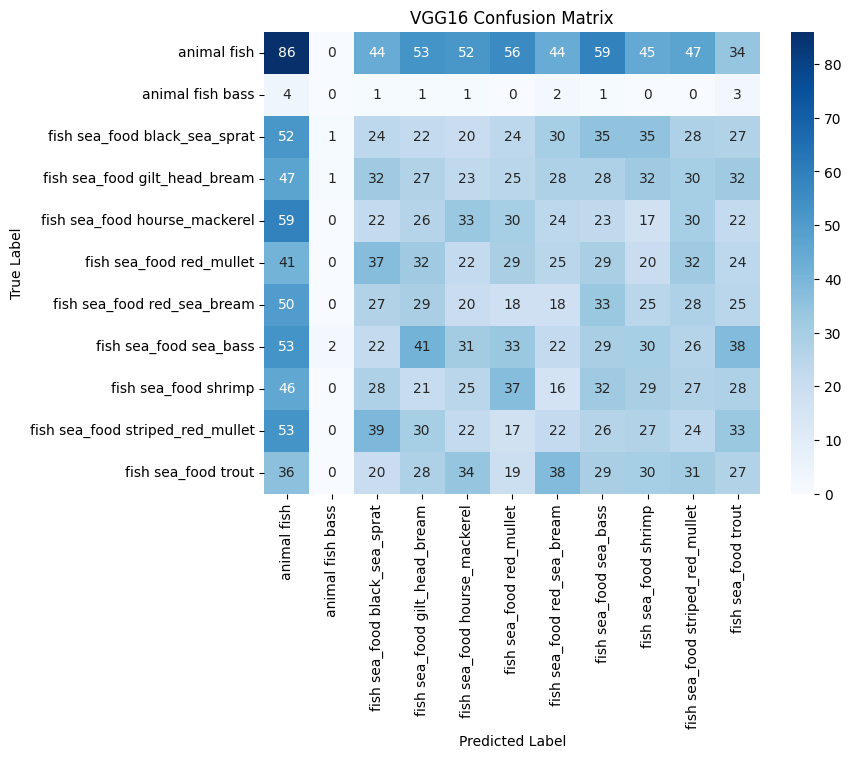

100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 283ms/step

--- MobileNetV2 Evaluation ---

Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.19      0.19      0.19       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.09      0.09      0.09       298
   fish sea_food gilt_head_bream       0.10      0.10      0.10       305
   fish sea_food hourse_mackerel       0.09      0.09      0.09       286
        fish sea_food red_mullet       0.09      0.09      0.09       291
     fish sea_food red_sea_bream       0.07      0.07      0.07       273
          fish sea_food sea_bass       0.12      0.12      0.12       327
            fish sea_food shrimp       0.08      0.08      0.08       289
fish sea_food striped_red_mullet       0.11      0.11      0.11       293
             fish sea_food trout       0.09      0.09      0.09       292

          

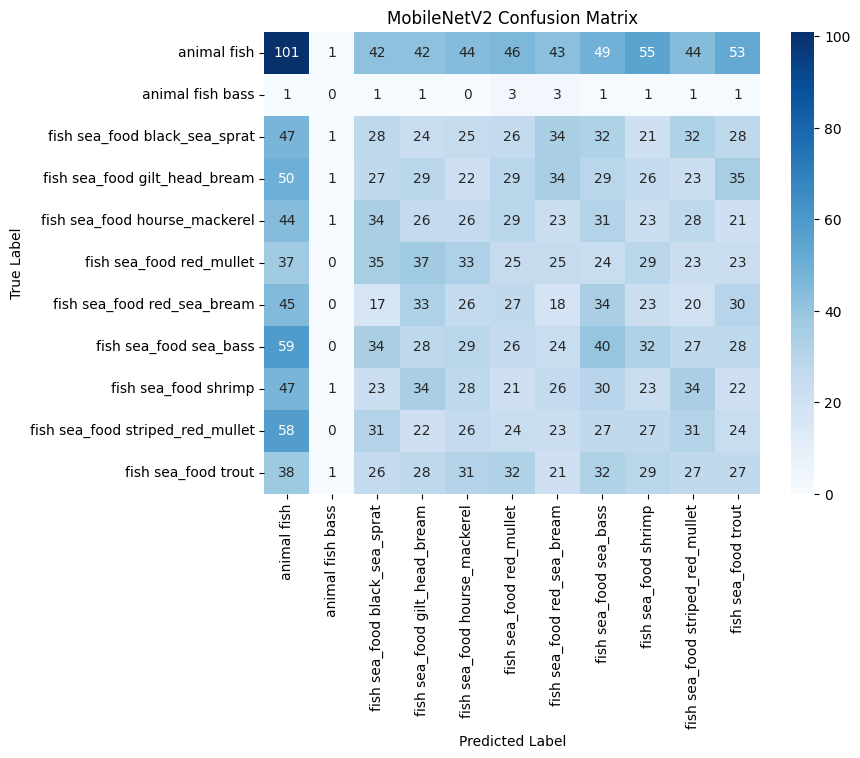

100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 398ms/step

--- EfficientNetB0 Evaluation ---

Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.16      1.00      0.28       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.00      0.00      0.00       298
   fish sea_food gilt_head_bream       0.00      0.00      0.00       305
   fish sea_food hourse_mackerel       0.00      0.00      0.00       286
        fish sea_food red_mullet       0.00      0.00      0.00       291
     fish sea_food red_sea_bream       0.00      0.00      0.00       273
          fish sea_food sea_bass       0.00      0.00      0.00       327
            fish sea_food shrimp       0.00      0.00      0.00       289
fish sea_food striped_red_mullet       0.00      0.00      0.00       293
             fish sea_food trout       0.00      0.00      0.00       292

       

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


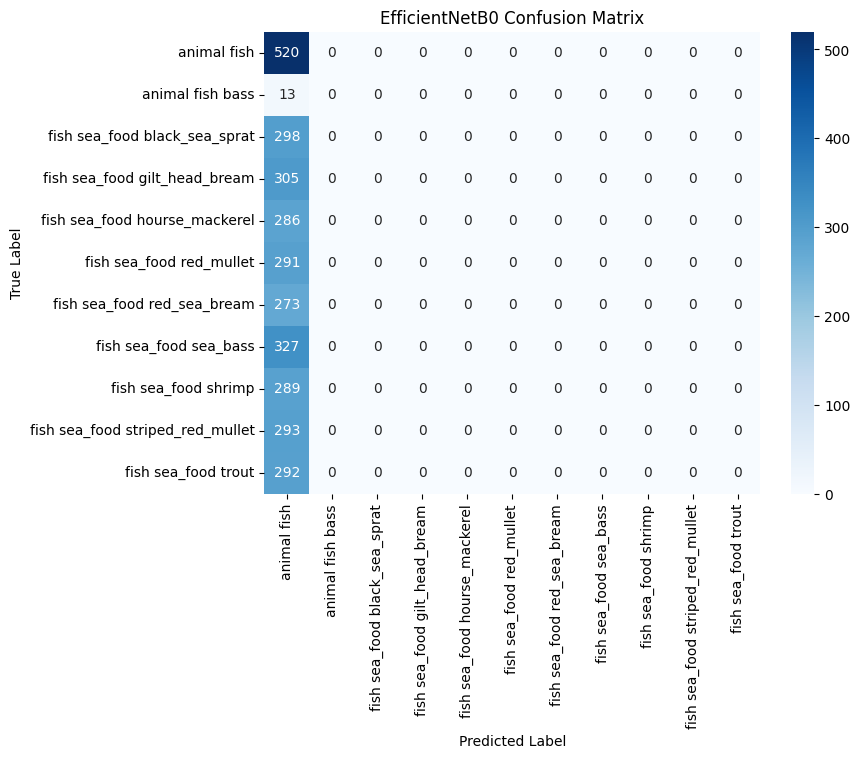

100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 656ms/step

--- InceptionV3 Evaluation ---

Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.18      0.18      0.18       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.10      0.09      0.09       298
   fish sea_food gilt_head_bream       0.10      0.10      0.10       305
   fish sea_food hourse_mackerel       0.11      0.11      0.11       286
        fish sea_food red_mullet       0.09      0.09      0.09       291
     fish sea_food red_sea_bream       0.08      0.08      0.08       273
          fish sea_food sea_bass       0.12      0.12      0.12       327
            fish sea_food shrimp       0.09      0.09      0.09       289
fish sea_food striped_red_mullet       0.10      0.10      0.10       293
             fish sea_food trout       0.08      0.08      0.08       292

          

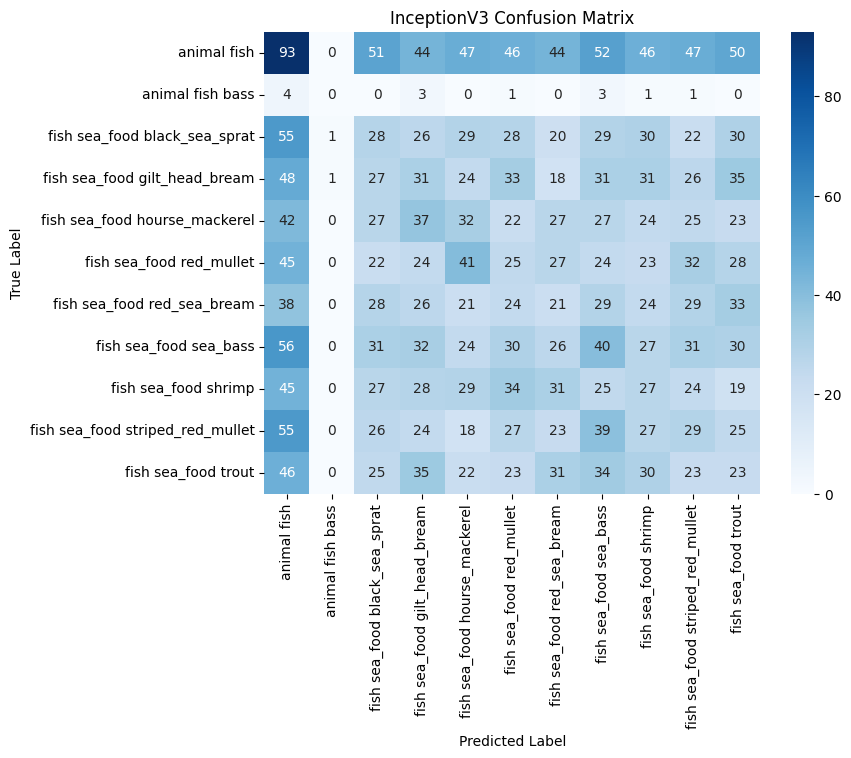

100/100 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step

--- ResNet50 Evaluation ---

Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.15      0.44      0.23       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.24      0.02      0.04       298
   fish sea_food gilt_head_bream       0.11      0.06      0.08       305
   fish sea_food hourse_mackerel       0.08      0.12      0.10       286
        fish sea_food red_mullet       0.07      0.15      0.10       291
     fish sea_food red_sea_bream       0.06      0.03      0.04       273
          fish sea_food sea_bass       0.06      0.01      0.01       327
            fish sea_food shrimp       0.09      0.01      0.02       289
fish sea_food striped_red_mullet       0.08      0.00      0.01       293
             fish sea_food trout       0.11      0.08      0.09       292

               

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


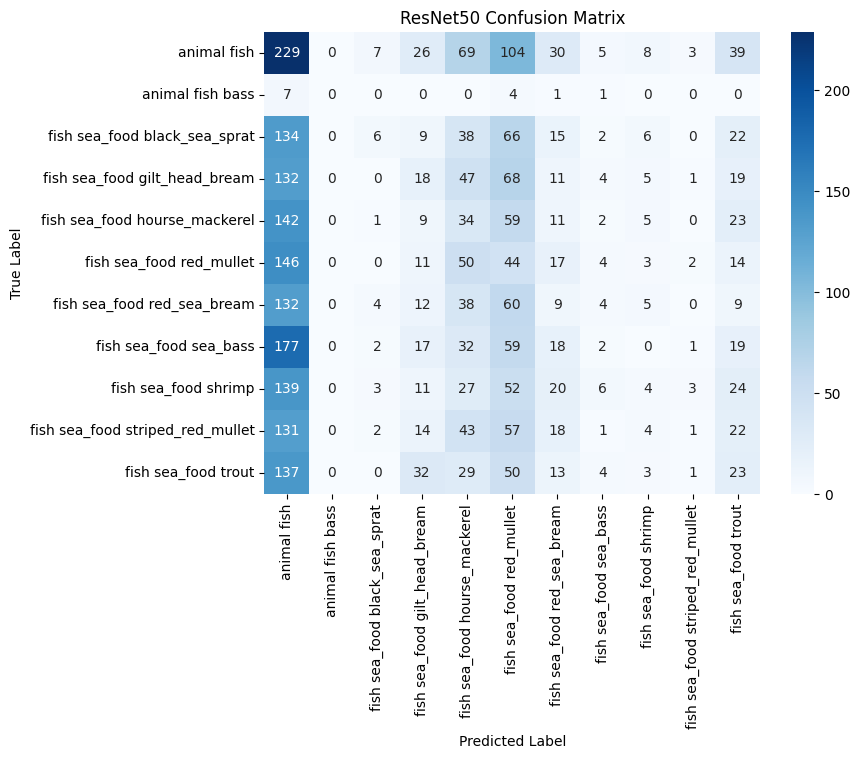

In [21]:
def evaluate_model(model, test_generator, model_name, class_names):
    test_generator.reset()
    Y_pred = model.predict(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = test_generator.classes
    print(f"\n--- {model_name} Evaluation ---")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Evaluate all models
evaluate_model(custom_cnn_model, test_generator, 'Custom CNN', class_names)
evaluate_model(vgg16_model, test_generator, 'VGG16', class_names)
evaluate_model(mobilenet_model, test_generator, 'MobileNetV2', class_names)
evaluate_model(efficientnetb0_model, test_generator, 'EfficientNetB0', class_names)
evaluate_model(inceptionv3_model, test_generator, 'InceptionV3', class_names)
evaluate_model(resnet50_model, test_generator, 'ResNet50', class_names)

#### Lets understand the UndefinedMetricWarning
The UndefinedMetricWarning and the 0.0 values you see in the classification reports for EfficientNetB0 and ResNet50 are not errors, but rather a sign that your models are not making any predictions for certain classes.

What is Precision? Precision is a measure of a model's accuracy on a specific class. It's calculated as the ratio of true positives (correct predictions) to the sum of true positives and false positives (incorrect predictions). In simpler terms, it answers: "Of all the times the model predicted this class, how many were actually correct?"

Why are you seeing the warning? The warning message itself provides the answer: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

For your EfficientNetB0 model, the classification report shows a recall of 1.00 for the 'animal fish' class and 0.00 for all other classes. This indicates that the model is predicting every image as animal fish.

Since the model never predicts any other class (e.g., fish sea_food black_sea_sprat), the denominator for the precision calculation for that class is zero, making the precision undefined. Scikit-learn handles this by setting the value to 0.0 and issuing a warning.

Why is this happening? This behavior is a strong indicator of a severely imbalanced dataset. Your data has 520 images for 'animal fish' but only 13 for 'animal fish bass'. The models, especially EfficientNetB0, have learned that the safest way to achieve the highest possible overall accuracy is to just predict the most common class.